In [133]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Readme
Change dataset, crop_id, obj_id only

# 1. Crop images

In [229]:
# load sam
from src.model.sam import CustomSamAutomaticMaskGenerator, load_sam
from segment_anything.modeling.sam import Sam

def move_to_device(segmentor_model, device="cuda"):
    # if there is predictor in the model, move it to device
    if hasattr(segmentor_model, "predictor"):
        segmentor_model.predictor.model = (
            segmentor_model.predictor.model.to(device)
        )
    else:
        segmentor_model.model.setup_model(device=device, verbose=True)
        
model_type = "vit_h"
checkpoint_dir =  "datasets/bop23_challenge/pretrained/segment-anything"
sam_model = load_sam(model_type, checkpoint_dir)
custom_sam_model = CustomSamAutomaticMaskGenerator(sam=sam_model) #, crop_overlap_ratio = 750 / 1500) # , box_nms_thresh = 0.6 )
move_to_device(custom_sam_model)

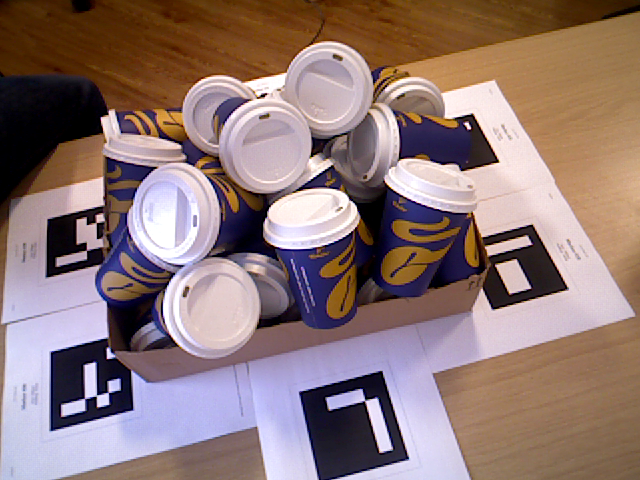

In [230]:
from PIL import Image
import torch
import numpy as np
from src.model.utils import Detections

dataset = "icbin"
rgb_path = "datasets/bop23_challenge/datasets/icbin/test/000001/rgb/000010.png" # f"datasets/bop23_challenge/datasets/{dataset}/test/000048/rgb/000001.png"
rgb = Image.open(rgb_path).convert("RGB")
sam_detections = custom_sam_model.generate_masks(np.array(rgb))
rgb

In [231]:
np.array(rgb).shape

(480, 640, 3)

In [232]:
from torchvision.ops.boxes import batched_nms, box_area


def _remove_very_small_detections(masks, boxes): # after this step only valid boxes, masks are saved, other are filtered out
        min_box_size = 0.05 # relative to image size 
        min_mask_size = 300/(640*480) # relative to image size assume the pixesl should be in range (300, 10000) need to remove them 
        max_mask_size = 10000/(640*480) 
        img_area = masks.shape[1] * masks.shape[2]
        box_areas = box_area(boxes) / img_area
        formatted_values = [f'{value.item():.6f}' for value in box_areas*img_area]
        mask_areas = masks.sum(dim=(1, 2)) / img_area
        keep_idxs = torch.logical_and(
            torch.logical_and(mask_areas > min_mask_size, mask_areas < max_mask_size),
            box_areas > min_box_size**2
        )

        return keep_idxs

keep_ids = _remove_very_small_detections(sam_detections["masks"], sam_detections["boxes"])

selected_masks = [sam_detections["masks"][i] for i in range(len(keep_ids)) if keep_ids[i]]
selected_bboxes = [sam_detections["boxes"][i] for i in range(len(keep_ids)) if keep_ids[i]]

selected_sam_detections = {
        "masks" : torch.stack(selected_masks),
        "boxes" : torch.stack(selected_bboxes)
}

print(len(selected_sam_detections["masks"]))
print(len(sam_detections["masks"]))

69
105


In [233]:
del custom_sam_model

In [234]:
def extract_object_by_mask(image, mask, width: int = 512):
    mask = Image.fromarray(mask)
    masked_image = Image.composite(
        image, Image.new("RGB", image.size, (0, 0, 0)), mask)
    cropped_image = masked_image.crop(masked_image.getbbox())
    # new_height = width * cropped_image.height // cropped_image.width
    return cropped_image

masked_images = []
for mask in selected_sam_detections["masks"].cpu():
    binary_mask = np.array(mask) * 255
    binary_mask = binary_mask.astype(np.uint8)
    masked_image = extract_object_by_mask(rgb, binary_mask)
    masked_images.append(masked_image)

In [235]:
len(masked_images)

69

In [236]:
# # Visualize proposals
# import matplotlib.pyplot as plt
# from math import ceil
# def plot_images(images, rows, cols):
#     fig, axes = plt.subplots(rows, cols, figsize=(20, 30))
#     for i, ax in enumerate(axes.flat):
#         if i >= len(images):
#             break
#         ax.imshow(images[i])
#         ax.axis('off')
#     plt.tight_layout()
#     plt.show()

# # Define the number of rows and columns in the grid
# rows = ceil(len(masked_images) / 6)
# cols = 6
# # Plot the masked_images array in a grid
# plot_images(masked_images, rows, cols) 

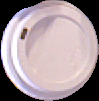

In [237]:
import os

# Choose crop 4 it is in object id 12
crop_idx = 2 # 125, 102 for background; 131 for foreground
obj_id = 1
crop1 = {
    "crop" : masked_images[crop_idx], # it is saved as Image so crop1["crop"] to visualize it
    "masks" : sam_detections["masks"][crop_idx],
    "boxes" : sam_detections["boxes"][crop_idx]
}

# Save image
if not os.path.exists(f"foundpose_analysis/{dataset}"):
    os.makedirs(f"foundpose_analysis/{dataset}")
crop1["crop"].save(f"foundpose_analysis/{dataset}/crop1.png")
crop1["crop"]

# 2. Templates

## 2.1 Create templates of object

In [238]:
# load config file
import hydra
from omegaconf import DictConfig, OmegaConf
from hydra import initialize, compose

# Initialize Hydra and compose the configuration
# initialize(config_path="configs")
cfg = compose(config_name="run_inference")
OmegaConf.set_struct(cfg, False)

In [239]:
import os
import glob

default_ref_dataloader_config = cfg.data.reference_dataloader
ref_dataloader_config = default_ref_dataloader_config.copy()
ref_dataloader_config._target_ = "src.dataloader.bop_pbr.BOPTemplatePBR"
ref_dataloader_config.root_dir = f"datasets/bop23_challenge/datasets/{dataset}"
ref_dataloader_config.template_dir = " "

level_template = 1 # Level 0 :42 templates, level 1, 162 templates
ref_dataloader_config.level_templates = level_template 
ref_dataloader_config.split = "train_pbr" # train_pbr

ply_files = glob.glob(f"datasets/bop23_challenge/datasets/{dataset}/models/models/*.ply")
obj_ids = sorted([int(os.path.basename(obj_id)[8:10]) for obj_id in ply_files])
ref_dataloader_config.obj_ids = obj_ids

out_folder = f"foundpose_analysis/{dataset}/templates"
if not os.path.exists(out_folder):
    os.makedirs(out_folder)
ref_dataloader_config.out_dir = out_folder
ref_dataloader_config.templates_output_folder = f"{out_folder}/level_template_{level_template}"

In [240]:
# import os
# os.environ['HYDRA_FULL_ERROR'] = '1'

In [241]:
# # Error : must delete all metadata.csv 
# # If using test it can happen that the object id doesnt appear in the test folder- so can get empty list - just use try except la ok
# from hydra.utils import instantiate
# ref_dataset = instantiate(ref_dataloader_config) # src.dataloader.bop.BOPTemplatePBR
# ref_dataset.load_processed_metaData(reset_metaData=True)

In [242]:
# from torchvision.utils import save_image
# import pandas as pd

# templates = pd.read_csv(f"{out_folder}/{ref_dataloader_config.split}_processed_metaData.csv")

# # Save templates as images
# for ob_id in range(len(obj_ids)): 
#     obj_id_path = os.path.join(f"{out_folder}/{ref_dataloader_config.split}_images_templates", f'obj_{(ob_id+1):06d}') # The transformed templates - check line 244, 245 in bop_pbr.py
#     original_obj_id_path = os.path.join(f"{out_folder}/{ref_dataloader_config.split}_images_templates", f'obj_{(ob_id+1):06d}_original')
    
#     if not os.path.exists(obj_id_path):
#         os.makedirs(obj_id_path)
#     if not os.path.exists(original_obj_id_path):
#         os.makedirs(original_obj_id_path)

#     try:  
#         for i, img in enumerate(ref_dataset[ob_id]["templates"]): # all the crop her is normalize and resize to 224*224 alsready in __getitem__
#             save_image(img, os.path.join(obj_id_path, f'{i:06d}.png'))
#         for i, img in enumerate(ref_dataset[ob_id]["original_templates"]): # all the crop her is normalize and resize to 224*224 alsready in __getitem__
#             save_image(img, os.path.join(original_obj_id_path, f'{i:06d}.png'))
#     except Exception as e:
#         print(f"An error occurred: {e}")

## 2.2. Templates features extraction

In [243]:
import glob
import os

obj_id_2 = 2
real_data_type = "test" # test

# Load original templates when before putting through dinov2 we also apply transfomation.
real_template_path_1 = f"{out_folder}/{real_data_type}_images_templates/obj_{obj_id:06d}_original" 
real_template_path_2 = f"{out_folder}/{real_data_type}_images_templates/obj_{obj_id_2:06d}_original" 
real_template_files_1 = sorted(glob.glob(os.path.join(real_template_path_1, "*.png")), key=os.path.getmtime)
real_template_files_2 = sorted(glob.glob(os.path.join(real_template_path_2, "*.png")), key=os.path.getmtime)
real_template_files = real_template_files_1 # + real_template_files_2
real_num_templates = len(real_template_files)
real_num_templates

0

In [244]:
import glob
import os

obj_id_2 = 2
syn_data_type = "train_pbr" # test

# Load original templates when before putting through dinov2 we also apply transformation.
syn_template_path_1 = f"{out_folder}/{syn_data_type}_images_templates/obj_{obj_id:06d}_original" 
syn_template_path_2 = f"{out_folder}/{syn_data_type}_images_templates/obj_{obj_id_2:06d}_original" 
syn_template_files_1 = sorted(glob.glob(os.path.join(syn_template_path_1, "*.png")), key=os.path.getmtime)
syn_template_files_2 = sorted(glob.glob(os.path.join(syn_template_path_2, "*.png")), key=os.path.getmtime)
syn_template_files = syn_template_files_1 # + syn_template_files_2
syn_num_templates = len(syn_template_files)
syn_num_templates

162

In [245]:
import glob
import os

obj_id_2 = 2

# Load original templates when before putting through dinov2 we also apply transformation.
pyrender_template_path_1 = f"datasets/bop23_challenge/datasets/templates_pyrender/icbin/obj_{obj_id:06d}" 
pyrender_template_path_2 = f"datasets/bop23_challenge/datasets/templates_pyrender/icbin/obj_{obj_id_2:06d}" 
pyrender_template_files_1 = sorted(glob.glob(os.path.join(pyrender_template_path_1, "*.png")), key=os.path.getmtime)
pyrender_template_files_2 = sorted(glob.glob(os.path.join(pyrender_template_path_2, "*.png")), key=os.path.getmtime)
pyrender_template_files = pyrender_template_files_1 # + pyrender_template_files_2
pyrender_num_templates = len(pyrender_template_files)
pyrender_num_templates

162

In [246]:
from PIL import Image
import numpy as np


# [50:450, 150:500, :3] only for pyrender template not for BlenderProc templates
real_templates = [np.array(Image.open(template_file).convert("RGB"))[:,:,:3] for template_file in real_template_files] # This image has 4 channels- the last one is not crucial - maybe about opacity
syn_templates = [np.array(Image.open(template_file).convert("RGB"))[:,:,:3]/255.0 for template_file in syn_template_files] # This image has 4 channels- the last one is not crucial - maybe about opacity
pyrender_templates = [np.array(Image.open(template_file).convert("RGB"))[50:450, 150:500, :3]/255.0 for template_file in pyrender_template_files]

# 3. Compare using trained model

## 3.1 Use Clssification Model

In [247]:
from src.model.custom_cnos import check_similarity, check_similarity_2


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model_path = "contrastive_learning/saved_checkpoints/best_model_checkpoint.pth"
crop_path = "cnos_analysis/crop_proposals/crop1.png"
crop_rgb = np.transpose(np.array(Image.open(crop_path).convert("RGB"))[:,:,:3]/255.0, (2,0,1)) # (124, 157, 3)

# Test model
check_similarity_2(best_model_path=best_model_path, crop_rgb=crop_rgb, templates=syn_templates, device=device)
# see the results lb it is quite inconsitent- it means we lack data augmentation and also the dataset needs to be expanded for more cases for postive pairs

Using cache found in /home/cuong.van-dam/.cache/torch/hub/facebookresearch_dinov2_main


Prediction of index161 is: tensor([0.1509, 0.1694, 0.1834, 0.1778, 0.1818, 0.1625, 0.1593, 0.1428, 0.1808,
        0.1908]), 0.1699482798576355 as 1


1

In [248]:
from src.model.custom_cnos import check_similarity_3
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model_path = "contrastive_learning/saved_checkpoints/best_model_checkpoint.pth"
aggreation_num_templates = 5
average_indices, max_indices, min_indices, average_prob, max_prob, min_prob = check_similarity_3(best_model_path=best_model_path, masked_images=masked_images, templates=syn_templates, aggreation_num_templates = aggreation_num_templates, device=device)
# see the results lb it is quite inconsitent- it means we lack data augmentation and also the dataset needs to be expanded for more cases for postive pairs

Using cache found in /home/cuong.van-dam/.cache/torch/hub/facebookresearch_dinov2_main


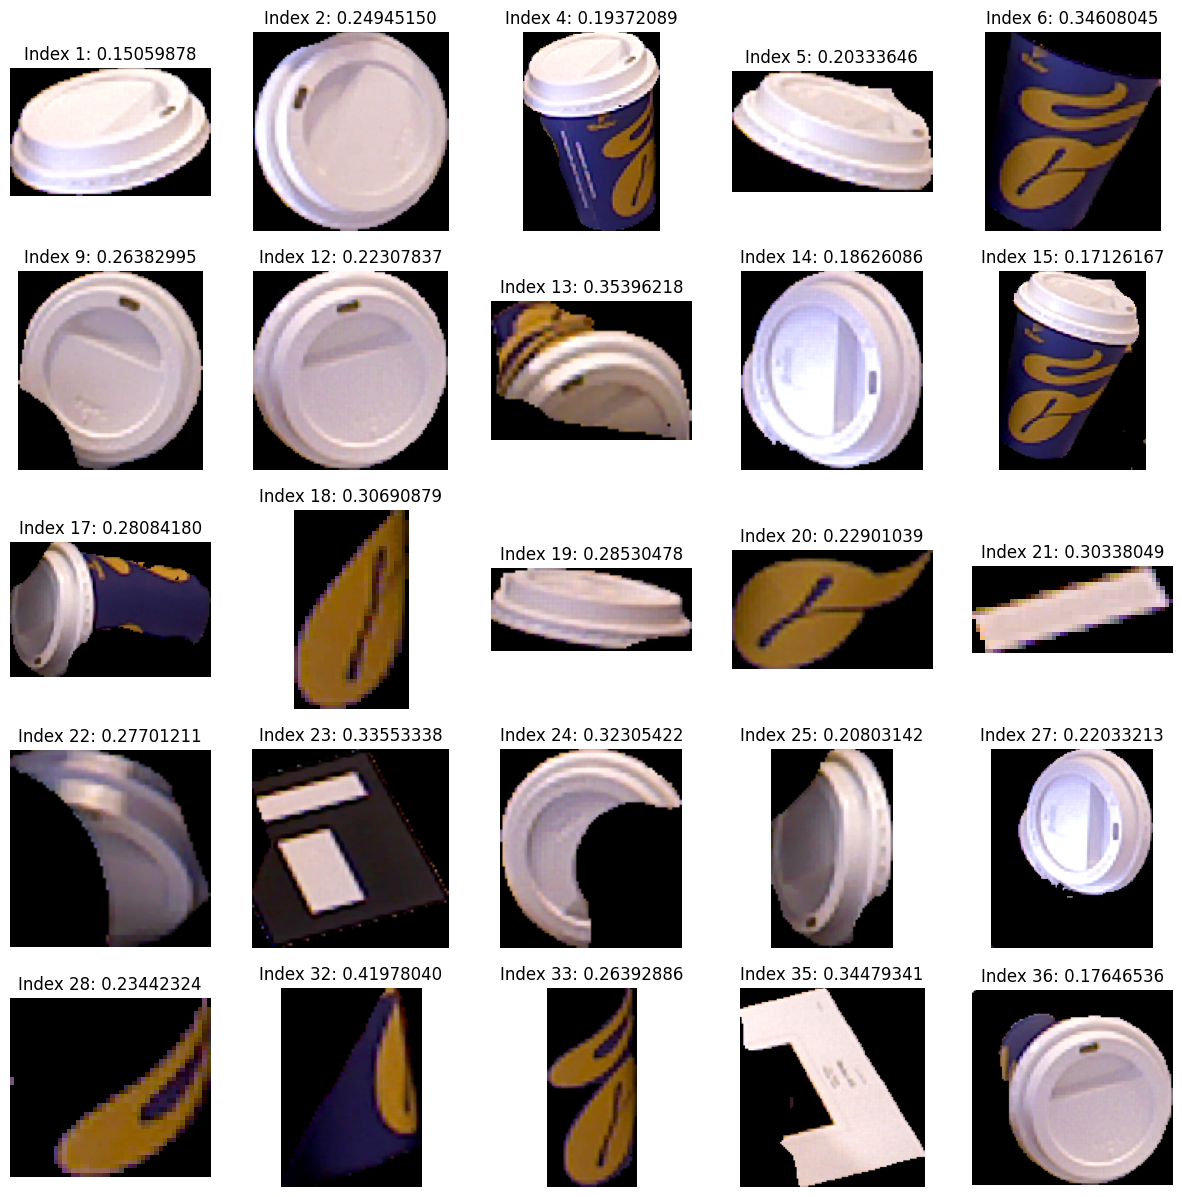

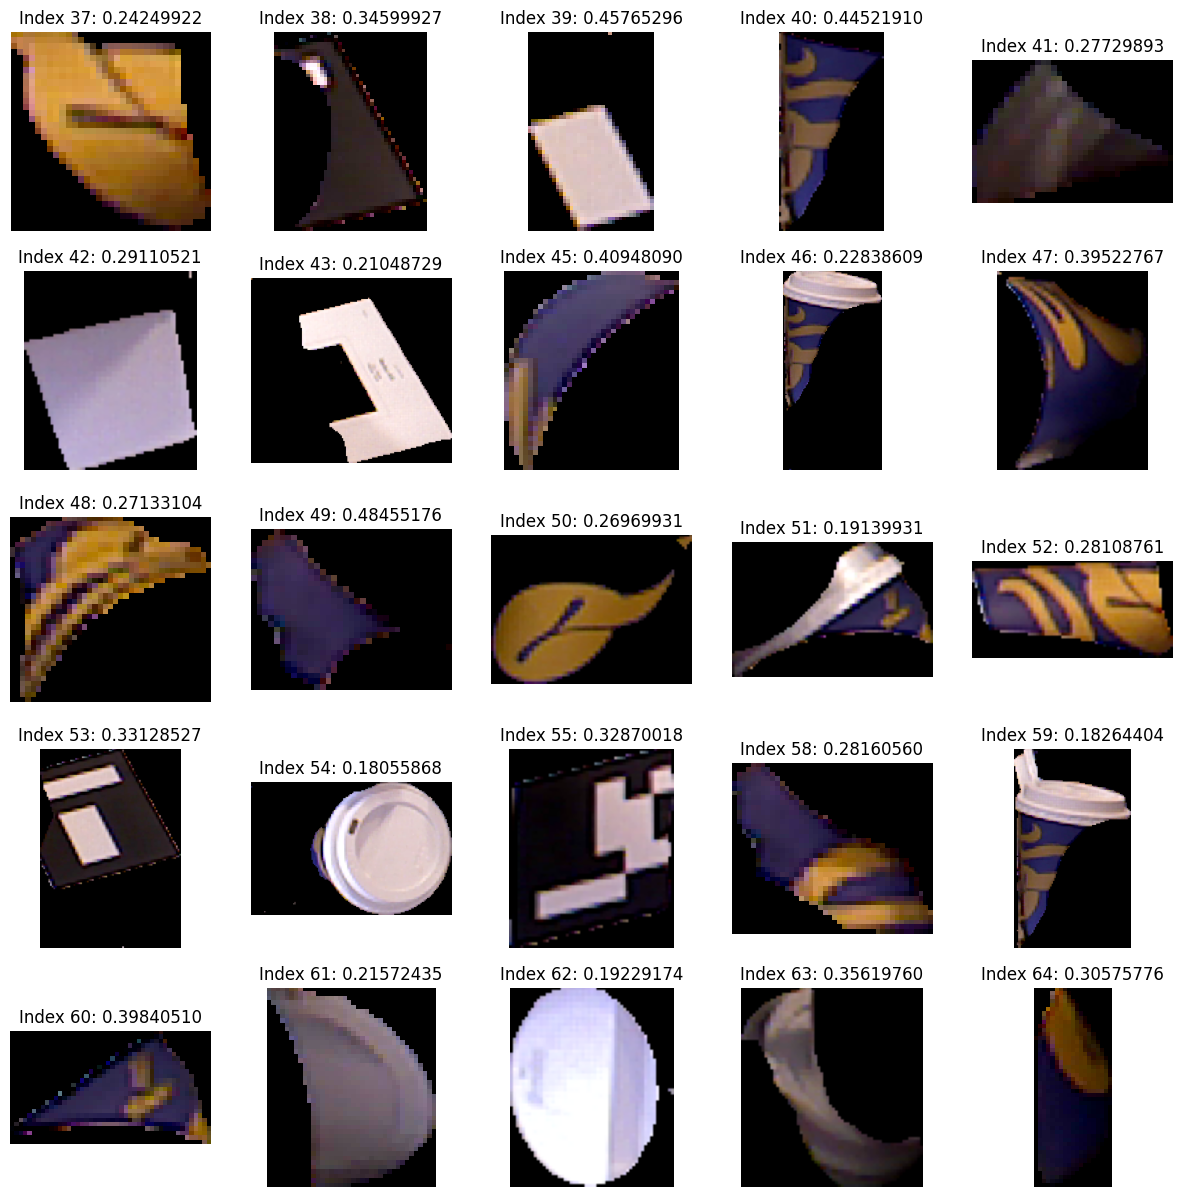

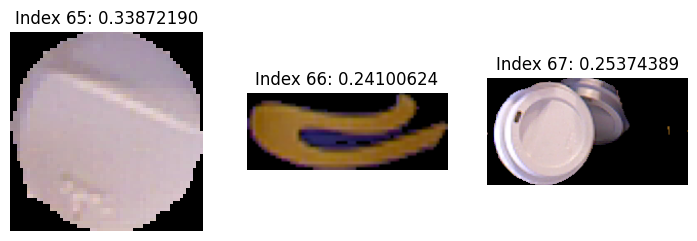

In [249]:
import matplotlib.pyplot as plt
import numpy as np

idx_selected_proposals = average_indices # torch.arange(len(masked_images)) #a
pred_probs = average_prob
# Number of images to display at a time
images_per_page = 25

# Define the number of rows and columns for the grid
rows = 5
cols = 5

# Iterate over the indices in idx_selected_proposals in steps of images_per_page
for i in range(0, len(idx_selected_proposals), images_per_page):
    # Create a new figure for each set of images
    plt.figure(figsize=(15, 15))

    for j in range(images_per_page):
        # Calculate the current index in idx_selected_proposals
        current_index = i + j

        # Check if the current index is within the bounds of idx_selected_proposals
        if current_index >= len(idx_selected_proposals):
            break

        # Get the image index from idx_selected_proposals
        image_index = idx_selected_proposals[current_index]
        image_prob = format(float(pred_probs[current_index].item()),".8f")

        # Add a subplot for the current image
        plt.subplot(rows, cols, j + 1)
        plt.imshow(np.array(masked_images[image_index]))
        plt.title(f"Index {image_index}: {image_prob}")
        plt.axis('off')

    # Display the figure containing the images
    plt.show()

In [250]:
len(min_indices)

57

File contrastive_learning/outputs/test.json does not exist.
File contrastive_learning/outputs/test.npz has been deleted.


100%|██████████| 53/53 [00:37<00:00,  1.43it/s]


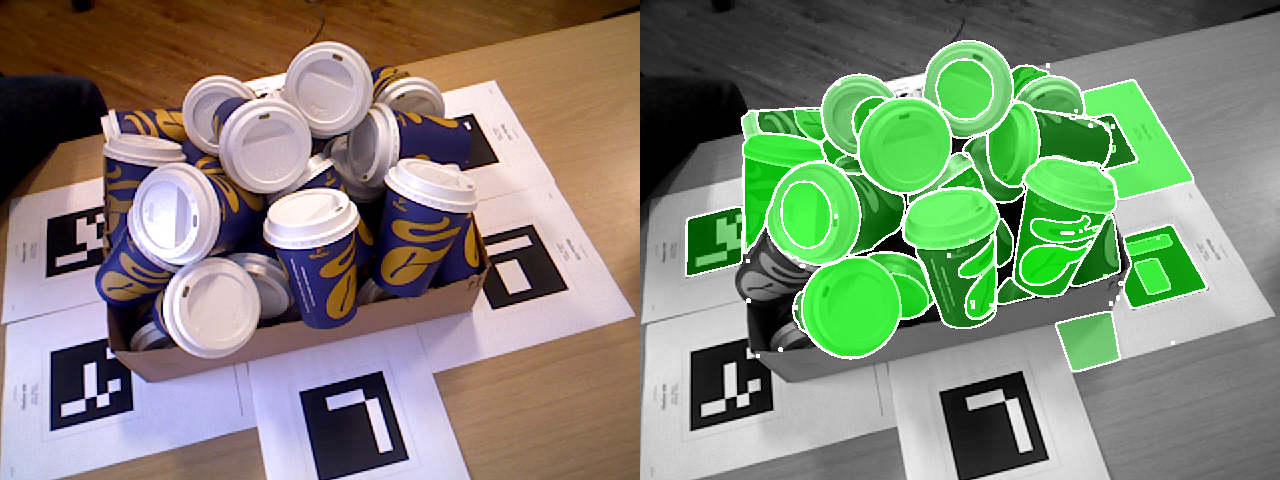

In [251]:
from src.model.custom_cnos import custom_detections, custom_visualize, custom_detections_2, custom_visualize_2

scene_id = 1
image_id = 1
dataset_name = "icbin"
# rgb_path = 'datasets/bop23_challenge/datasets/icbin/train_pbr/000001/rgb/000000.jpg'
file_path = f"contrastive_learning/outputs/{real_data_type}"
custom_detections_2(selected_sam_detections, idx_selected_proposals, file_path, scene_id=1, frame_id=1)

results = np.load(file_path+".npz")
dets = []
for i in range(results["segmentation"].shape[0]):
    det = {
    "scene_id": results["scene_id"],
    "image_id": results["image_id"],
    "category_id": results["category_id"][i],
    "bbox": results["bbox"][i],
    "segmentation": results["segmentation"][i],
    }
    dets.append(det)

final_result = custom_visualize_2(dataset_name, rgb_path, dets)
final_result
# see the results lb- lots of white crops are confused and clssified as objects

In [252]:
len(code)

NameError: name 'code' is not defined

In [ ]:
def extract_object_by_mask(image, mask, width: int = 512):
    mask = Image.fromarray(mask)
    masked_image = Image.composite(
        image, Image.new("RGB", image.size, (0, 0, 0)), mask)
    cropped_image = masked_image.crop(masked_image.getbbox())
    # new_height = width * cropped_image.height // cropped_image.width
    return cropped_image

masked_images = []
for mask in sam_detections["masks"].cpu():
    binary_mask = np.array(mask) * 255
    binary_mask = binary_mask.astype(np.uint8)
    masked_image = extract_object_by_mask(rgb, binary_mask)
    masked_images.append(masked_image)

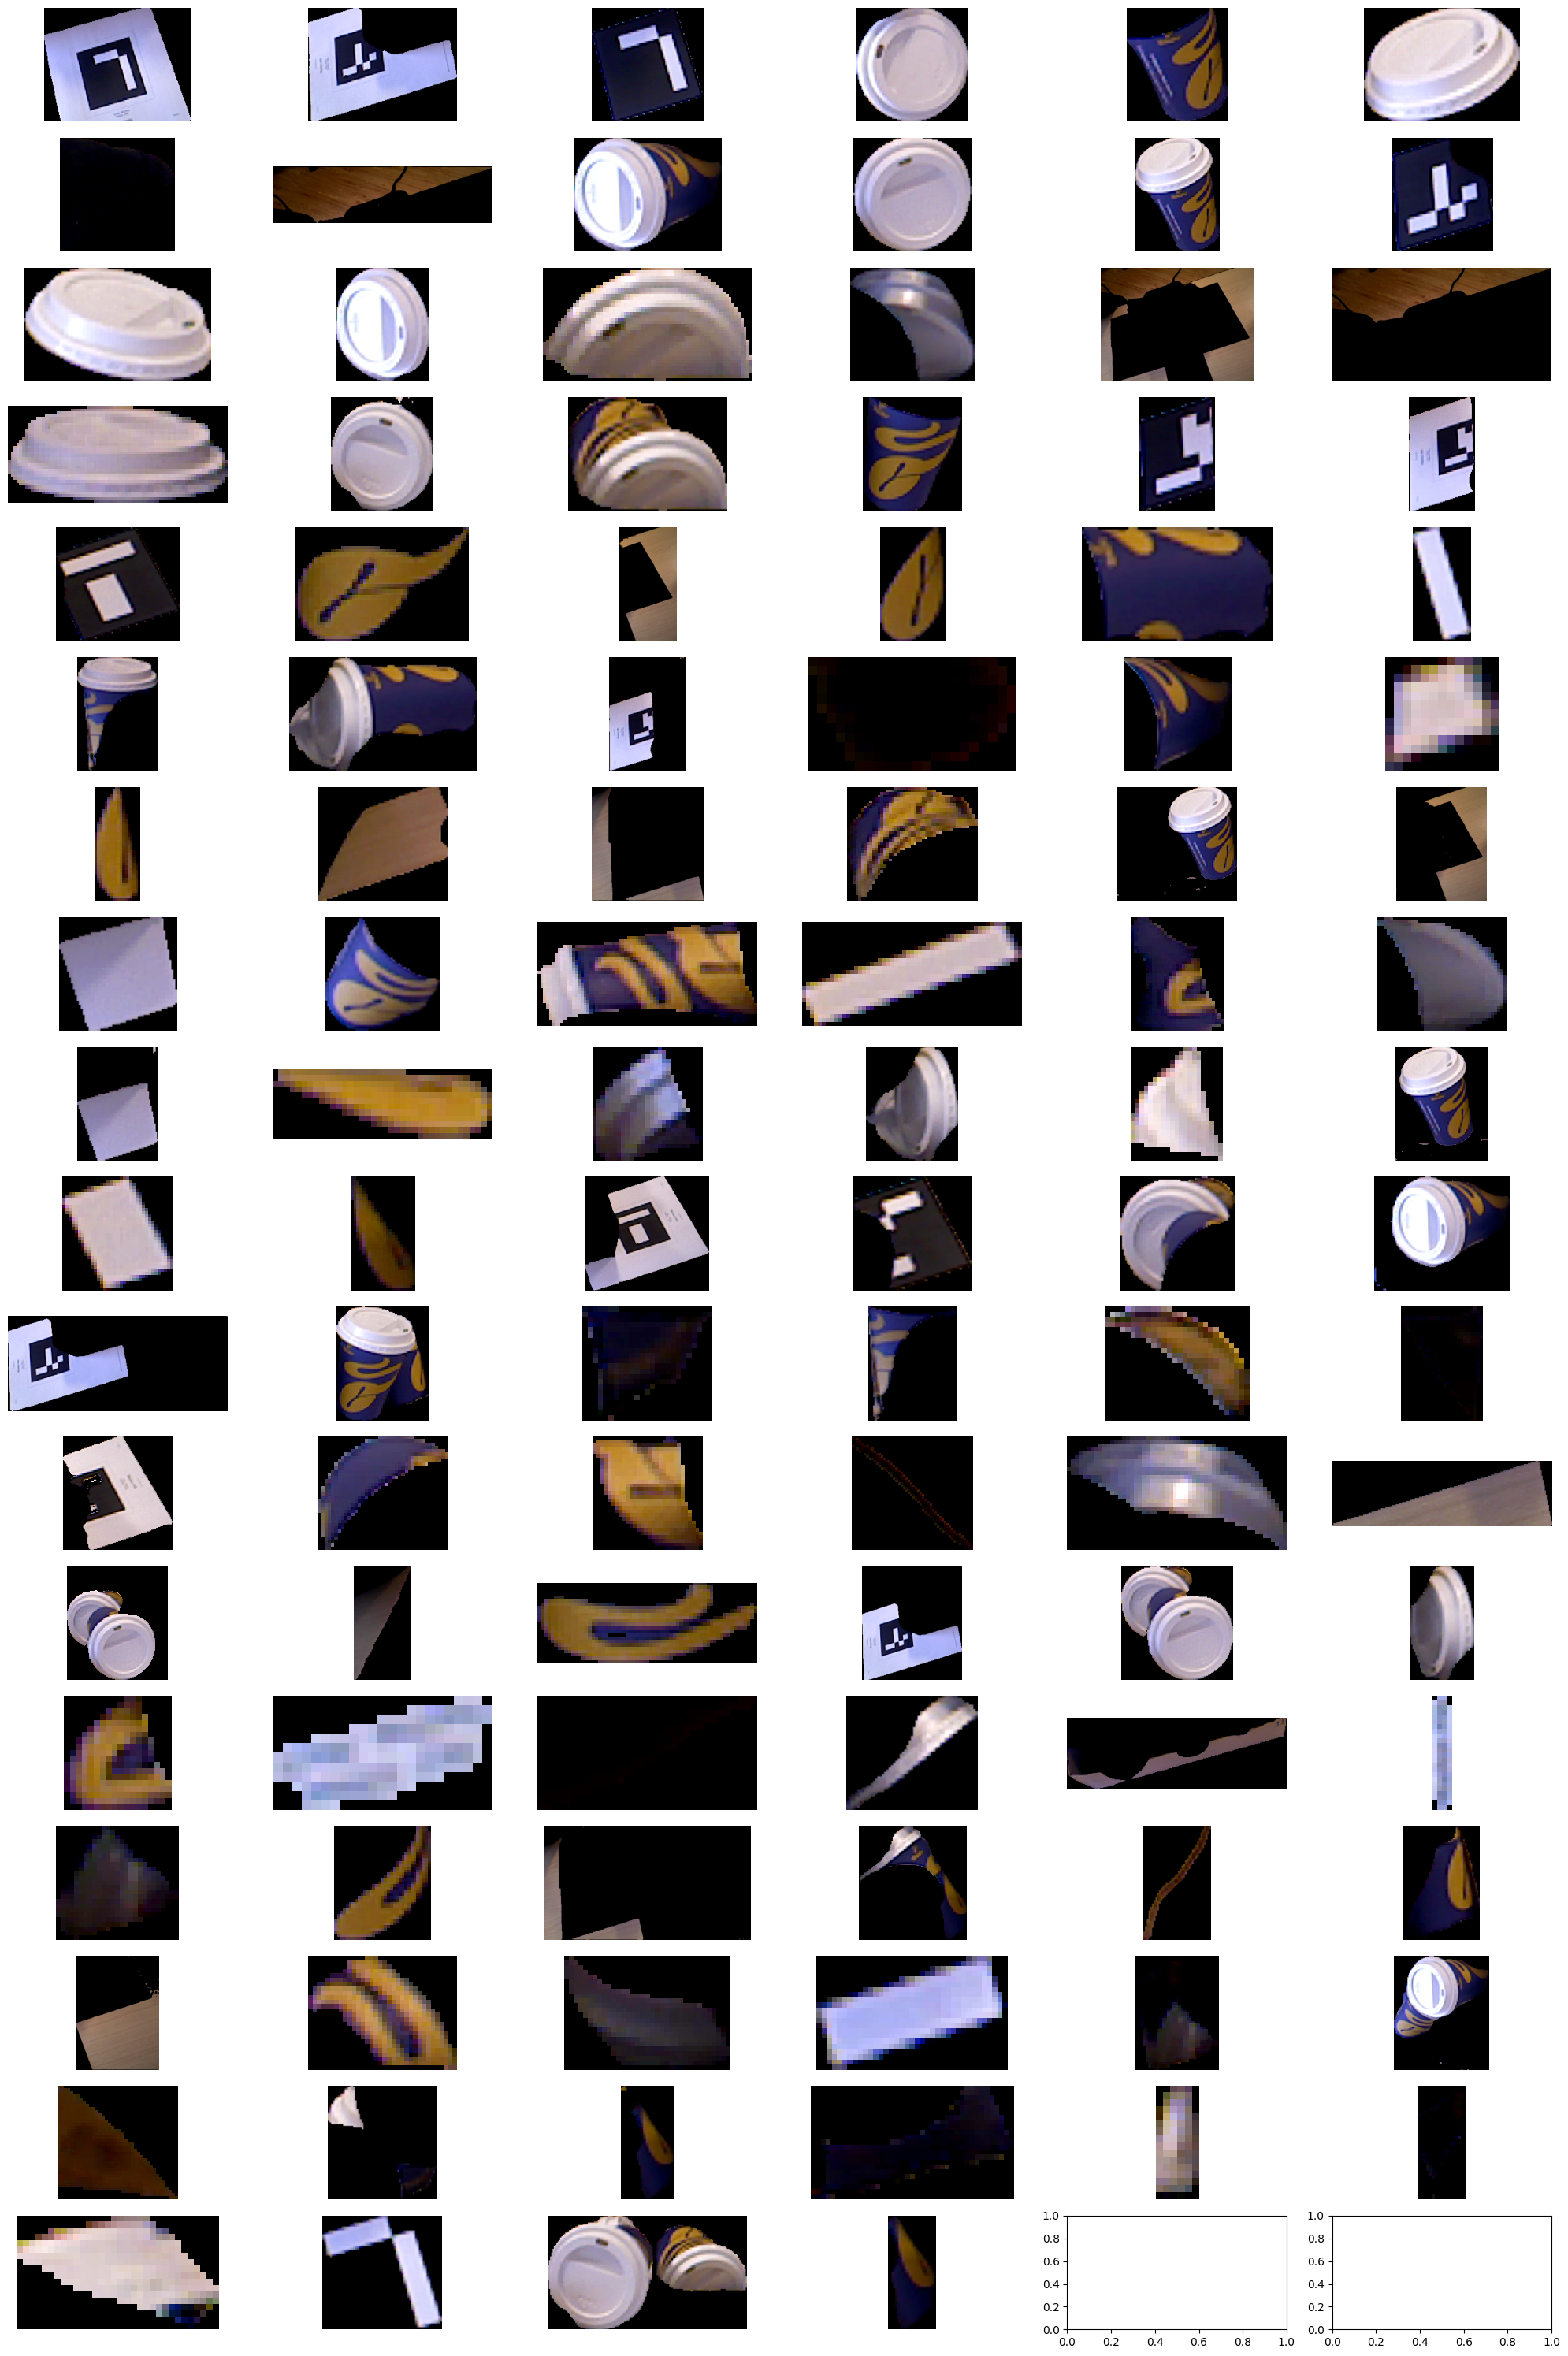

In [ ]:
# Visualize proposals
import matplotlib.pyplot as plt
from math import ceil
def plot_images(images, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 30))
    for i, ax in enumerate(axes.flat):
        if i >= len(images):
            break
        ax.imshow(images[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Define the number of rows and columns in the grid
rows = ceil(len(masked_images) / 6)
cols = 6
# Plot the masked_images array in a grid
plot_images(masked_images, rows, cols) 

In [ ]:
import os

# Choose crop 4 it is in object id 12
crop_idx = 79 # 125, 102 for background; 131 for foreground
obj_id = 1
crop1 = {
    "crop" : masked_images[crop_idx], # it is saved as Image so crop1["crop"] to visualize it
    "masks" : sam_detections["masks"][crop_idx],
    "boxes" : sam_detections["boxes"][crop_idx]
}

# Save image
if not os.path.exists(f"foundpose_analysis/{dataset}"):
    os.makedirs(f"foundpose_analysis/{dataset}")
crop1["crop"].save(f"foundpose_analysis/{dataset}/crop1.png")
crop1["crop"]

In [ ]:
from src.model.custom_cnos import check_similarity, check_similarity_2


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model_path = "contrastive_learning/saved_checkpoints/best_model_checkpoint.pth"
crop_path = f"foundpose_analysis/{dataset}/crop1.png"
crop_rgb = np.transpose(np.array(Image.open(crop_path).convert("RGB"))[:,:,:3]/255.0, (2,0,1)) # (124, 157, 3)

# Test model
check_similarity_2(best_model_path=best_model_path, crop_rgb=crop_rgb, templates=syn_templates, device=device)
# see the results lb it is quite inconsitent- it means we lack data augmentation and also the dataset needs to be expanded for more cases for postive pairs

Using cache found in /home/cuong.van-dam/.cache/torch/hub/facebookresearch_dinov2_main


Prediction of index161 is: tensor([2.4569, 2.5132, 2.5592, 2.4952, 2.5529, 2.5325, 2.5073, 2.5043, 2.5899,
        2.5093]), 2.5220718383789062 as 0


0

In [ ]:
Image.open(crop_path).convert("RGB")

## 3.2 Try out idea with Clip

In [ ]:
from torchvision.transforms import Compose, ToTensor, Normalize

def _convert_image_to_rgb(image):
    return image.convert("RGB")


def _transform(n_px):
    return Compose([
        # Resize(n_px, interpolation=BICUBIC),
        # CenterCrop(n_px),
        # _convert_image_to_rgb,
        ToTensor(),
        Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ])

process = _transform(224)


In [ ]:
from src.model.constrastive_learning import resize_and_pad_image

resized_masked_images = [Image.fromarray(np.array(resize_and_pad_image(np.transpose(np.array(masked_image), (2,0,1)), target_max=224).permute(1,2,0))) for masked_image in masked_images], # resize and pad images

In [ ]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)


# stacked_masked_images = torch.stack([preprocess(img).to(device) for img in masked_images])
stacked_masked_images = torch.stack([process(img).to(device) for img in resized_masked_images[0]]) # Resize to 224 beforehand already
text = clip.tokenize(["not a cup", "the rest"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(stacked_masked_images)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(stacked_masked_images, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

pred = np.argmax(probs, axis=1)
prob_max = np.max(probs, axis=1)
idx_selected = list(np.where(pred == 0)[0])
selected_prob_max = prob_max[idx_selected]
print(len(idx_selected))

80


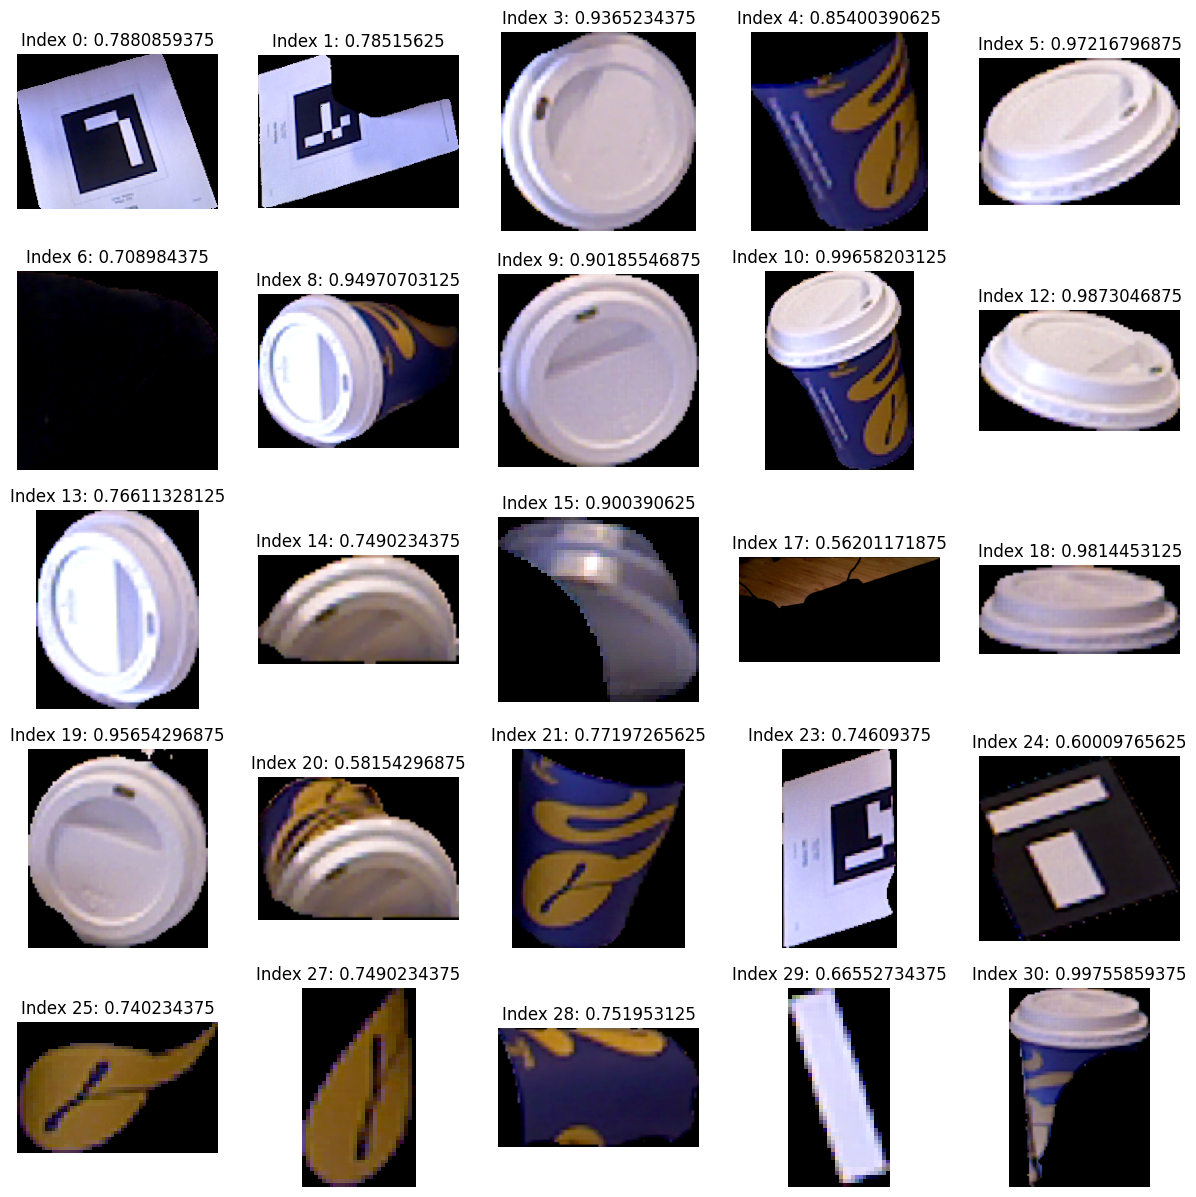

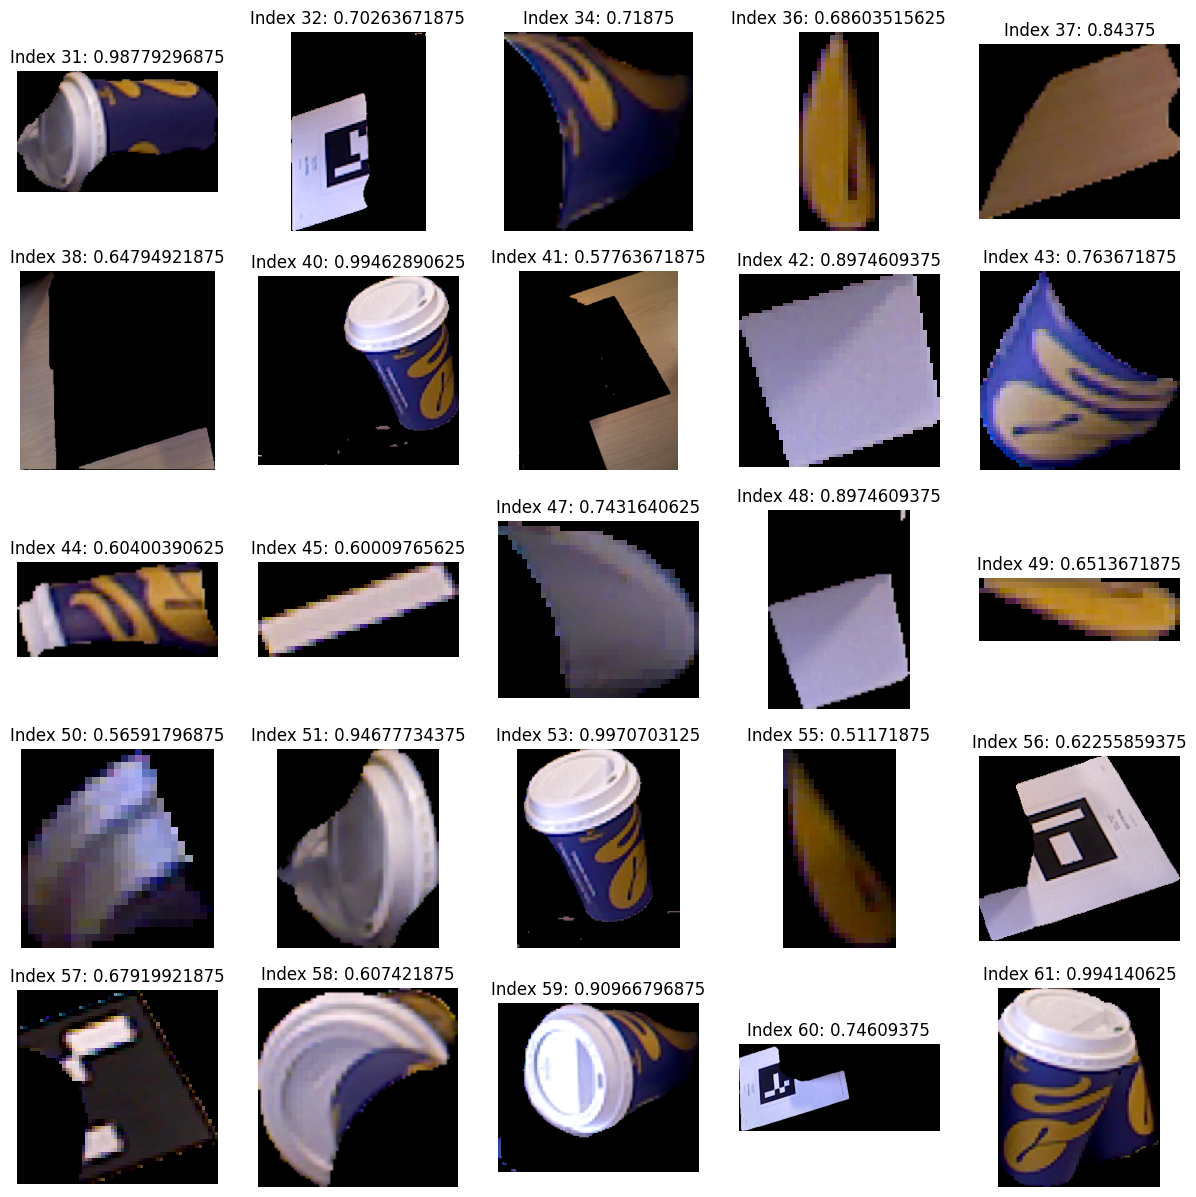

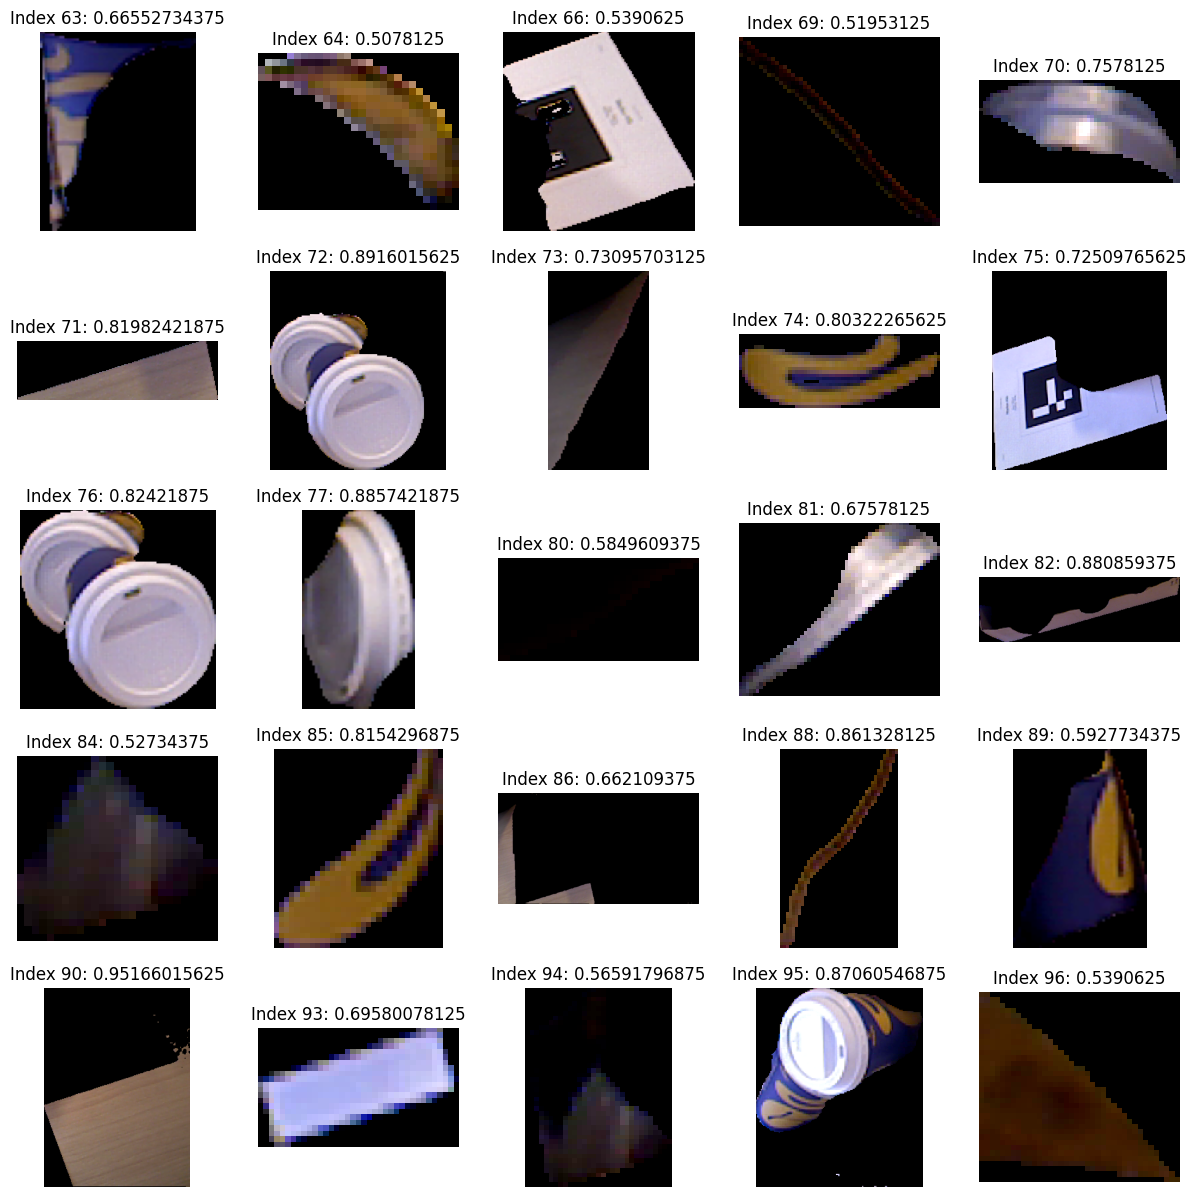

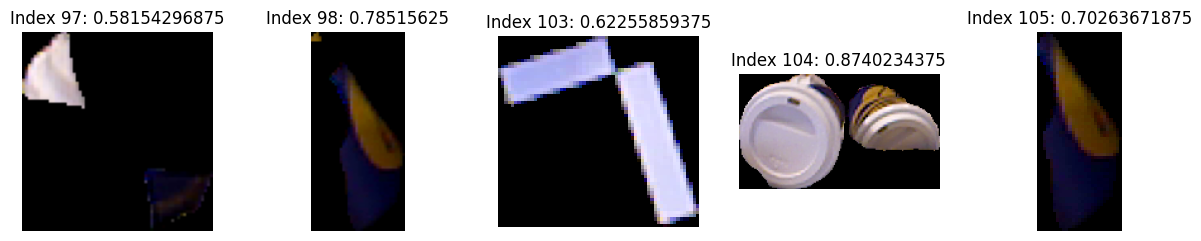

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Number of images to display at a time
images_per_page = 25

# Define the number of rows and columns for the grid
rows = 5
cols = 5

# Iterate over the indices in idx_selected_proposals in steps of images_per_page
for i in range(0, len(idx_selected), images_per_page):
    # Create a new figure for each set of images
    plt.figure(figsize=(15, 15))

    for j in range(images_per_page):
        # Calculate the current index in idx_selected_proposals
        current_index = i + j

        # Check if the current index is within the bounds of idx_selected_proposals
        if current_index >= len(idx_selected):
            break

        # Get the image index from idx_selected_proposals
        image_index = idx_selected[current_index]
        image_prob = selected_prob_max[current_index]

        # Add a subplot for the current image
        plt.subplot(rows, cols, j + 1)
        plt.imshow(np.array(masked_images[image_index]))
        plt.title(f"Index {image_index}: {image_prob}")
        plt.axis('off')

    # Display the figure containing the images
    plt.show()


In [ ]:
# Only choose crops with probability > 0.8
idx_selected_proposals = [idx_selected[i] for i in range(len(idx_selected)) if selected_prob_max[i]>0.8 ]

In [ ]:
# from src.model.custom_cnos import check_similarity, check_similarity_2

# masked_images_idx = 3
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# best_model_path = "contrastive_learning/saved_checkpoints/best_model_checkpoint_bce_seperate_model.pth"
# crop_path = "cnos_analysis/crop_proposals/crop1.png"
# crop_rgb = np.transpose(np.array(masked_images[masked_images_idx])[:,:,:3]/255.0, (2,0,1)) # (124, 157, 3)

# check_similarity_2(best_model_path=best_model_path, crop_rgb=crop_rgb, templates=syn_templates, device=device)
# # see the results lb it is quite inconsitent- it means we lack data augmentation and also the dataset needs to be expanded for more cases for postive pairs

In [ ]:
len(idx_selected_proposals)

31

# 4. Final Results